In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [340]:
def calc_ios(df):
    PAGESIZE = 4096
    if (df['nominal_compact_write'].sum() < 1):
        df['nominal_io'] = df['nominal_blocks_read']
        df['robust_io'] = df['robust_blocks_read']
    else:
        workload_weight = df['w_s'] / df['w_s'].sum()
        for mode in ['nominal', 'robust']:
            compaction_io = np.sum((df[f'{mode}_compact_read'] + df[f'{mode}_compact_write']) / PAGESIZE)
            df[f'{mode}_write_io'] = (workload_weight * compaction_io) + ((df[f'{mode}_bytes_written'] + df[f'{mode}_flush_written']) / PAGESIZE)
            df[f'{mode}_io'] = df[f'{mode}_blocks_read'] + df[f'{mode}_write_io']
    
    return df

def calc_latency(df, readonly=False):
    for mode in ['nominal', 'robust']:
        if readonly:
            write_ms = 0
        # Since we open and close the DB each workload we must spread out the waiting for compaction cost
        # as normally when we operate we would not stop all operations during backgorund compactions
        elif f'{mode}_compact_ms' not in df.columns:
            write_ms = 0
            write_ms = df[f'{mode}_w_ms'].sum()
            workload_weight = df['w_s'] / df['w_s'].sum()
            compact_normal_ms = write_ms * workload_weight
            write_ms = compact_normal_ms
        else:
            compact_normal_sum = df[f'{mode}_compact_ms'].sum() 
            workload_weight = df['w_s'] / df['w_s'].sum()
            compact_normal_ms = compact_normal_sum * workload_weight
            write_ms = df[f'{mode}_w_ms'] + compact_normal_ms
        df[f'{mode}_ms'] = (
            df[f'{mode}_z0_ms'] 
            + df[f'{mode}_z1_ms']
            + df[f'{mode}_q_ms']
            + write_ms)
    
    return df

def apply_design(df, cf, z0, z1, q, w, mode='nominal'):
    cf.z0, cf.z1, cf.q, cf.w = z0, z1, q, w
    cost = cf.calculate_cost(df[f'{mode}_m_filt'] / cf.N, np.ceil(df[f'{mode}_T']), df[f'{mode}_is_leveling_policy'])
    return cost

In [309]:
def plot_system_cost_sessions(df, ax):
    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    y1, y2 = df['nominal_io'] / df['num_queries'], df['robust_io'] / df['num_queries']
    
    ax.text(0.04, 0.82, 'System I/O', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels([]), ax.set_xticks([])
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8,
            label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}\n$\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8,
            label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}\n$\pi$: {robust_policy}')
    
    return ax

In [310]:
def plot_model_cost_sessions(df, ax, w0, w_hat):
    distance = np.sum(rel_entr(w_hat, w0))
    
    cfg = config['lsm_tree_config'].copy()
    cfg['N'], cfg['M'] = df.iloc[0].N, df.iloc[0].M
    cf = CostFunction(**cfg, z0=w_hat[0], z1=w_hat[1], q=w_hat[2], w=w_hat[3])
    df['nominal_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'nominal'), axis=1)
    df['robust_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'robust'), axis=1)

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    y1, y2 = df['nominal_cost'], df['robust_cost']
    
    ax.text(0.04, 0.82, 'Model I/O', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels([]), ax.set_xticks([])
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8,
            label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}\n$\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8,
            label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}\n$\pi$: {robust_policy}')
    
    return ax

In [311]:
def plot_latency_sessions(df, ax):
    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    y1, y2 = df['nominal_ms'] / df['num_queries'], df['robust_ms'] / df['num_queries']
    
    ax.text(0.02, 0.82, 'System Latency', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels([]), ax.set_xticks([])
    ax.set_ylabel('Latency (ms) per Query', labelpad=10)
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8,
            label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}\n$\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8,
            label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}\n$\pi$: {robust_policy}')
    
    return ax

In [332]:
def plot_cost_sessions(df, graphs=(True, True, True), readonly=False):
    sys, model, latency = graphs
    robust_rho = df.rho.iloc[0]
    num_sessions = int(df.session_id.max()) + 1
    samples = df[df['session_id'] == 0].shape[0]
    session_means = []
    for idx in range(0, df.shape[0], samples):
        session_means.append(df.iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w0 = [df['z0'].iloc[0], df['z1'].iloc[0], df['q'].iloc[0], df['w'].iloc[0]]
    distance = np.sum(rel_entr(w_hat, w0))

    fig, axes = plt.subplots(ncols=1, nrows=sum(graphs), tight_layout=True)
    axes = [axes] if sum(graphs) == 1 else axes
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
            
    # Graphs
    axes_it = iter(axes)
    if model:
        plot_model_cost_sessions(df, next(axes_it), w0, w_hat)
    if sys:
        plot_system_cost_sessions(df, next(axes_it))
    if latency:
        plot_latency_sessions(df, next(axes_it))
        
    if sys and model:
        tmp_fig = axes[0].get_figure()
        ax0 = tmp_fig.add_subplot(111, frame_on=False)
        ax0.set_xticks([]), ax0.set_yticks([])
        ax0.set_ylabel('I/Os per Query', labelpad=25)
        x, y = ax0.yaxis.label.get_position()
        ax0.yaxis.set_label_coords(x - 0.03, y + 0.25)
    elif sys or model:
        axes[0].set_ylabel('I/Os per Query')
    first_ax = axes[0]
    first_ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2, borderpad=0.2, labelspacing=-0.1)
    first_ax.text(0.845, 0.85,
        '$w_{' + f'{wl_idx if wl_idx < 15 else ""}' + '}:\ $' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)',
        transform=first_ax.transAxes, fontsize=13)
    first_ax.text(0.845, 0.65,
        '$\hat{w}:\ $' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)',
        transform=first_ax.transAxes, fontsize=13)

    # Last axes label
    last_ax = axes[-1]
    last_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    x_loc = [0.025, 0.200, 0.360, 0.535, 0.700, 0.870]
    for idx, x in enumerate(x_loc):
        z0, z1, q, w = session_means[idx]
        last_ax.text(x, -0.38, f'({(z0 * 100):.0f}%, {(z1 * 100):.0f}%, {(q  * 100):.0f}%, {(w  * 100):.0f}%)', alpha=1, transform=last_ax.transAxes)
    
    if readonly:
        last_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Reads', '6. Reads'])
    else:
        last_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])
    
    last_ax.text(0.85, 0.82, r'$\rho :$' + f'{robust_rho:.2f}', transform=last_ax.transAxes, fontsize=13)
    last_ax.text(0.85, 0.62, '$I_{KL}(\hat{w}, w) :$' + f'{distance:.2f}', transform=last_ax.transAxes, fontsize=13)

    return fig, axes

In [333]:
# df = dp.read_csv('exp_03_pt03_writes.csv')

In [334]:
# wl_idx, N, readonly = 8, 1e7, False
# graphs = (True, True, True)

# # df_slice = df[(df['workload_idx'] == wl_idx) & (df['N'] == N)].reset_index()
# # df_slice = calc_ios(df_slice)
# # df_slice = calc_latency(df_slice)

# # set_style()
# # fig, axes = plot_cost_sessions(df_slice, graphs)
# # ymax = max([ax.get_ylim()[1] for ax in axes])
# # axes[0].set_ylim([0, ymax])
# # axes[1].set_ylim([0, ymax])
# # set_size(fig, width=14, height=sum(graphs)*2)

# for wl_idx in range(0, 17):
#     df_slice = df[(df['workload_idx'] == wl_idx) & (df['N'] == N)].reset_index()
#     df_slice = calc_ios(df_slice)
#     df_slice = calc_latency(df_slice)

#     set_style()
#     fig, axes = plot_cost_sessions(df_slice, graphs)
# #     ymax = max([ax.get_ylim()[1] for ax in axes])
#     axes[0].set_ylim([0, axes[0].get_ylim()[1] * 1.5])
# #     axes[1].set_ylim([0, ymax])
#     set_size(fig, width=14, height=sum(graphs)*2)

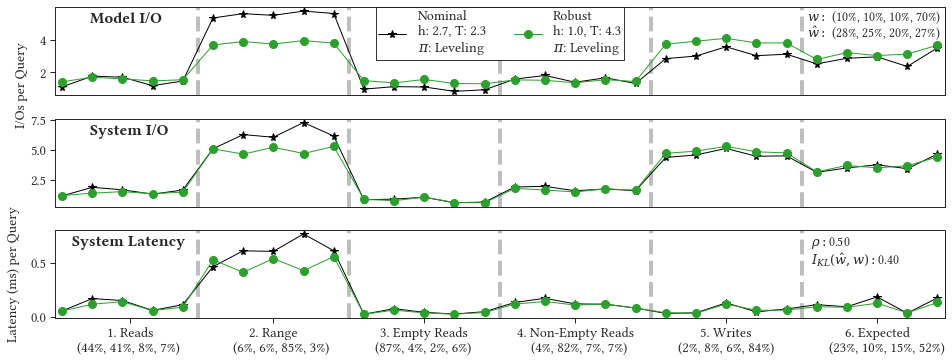

In [335]:
df = dp.read_csv('exp_03_pt01.csv')
wl_idx, N, readonly = 15, 1e7, False
graphs = (True, True, True)

df_slice = df[(df['workload_idx'] == wl_idx) & (df['N'] == N)].reset_index()
df_slice = calc_ios(df_slice)
df_slice = calc_latency(df_slice)

set_style()
fig, axes = plot_cost_sessions(df_slice, graphs)
# ymax = max([ax.get_ylim()[1] for ax in axes])
# axes[0].set_ylim([0, 12])
# axes[1].set_ylim([0, 12])
set_size(fig, width=14, height=sum(graphs)*1.75)
save_fig(fig, 'query_seq_hybrid_1.pdf')

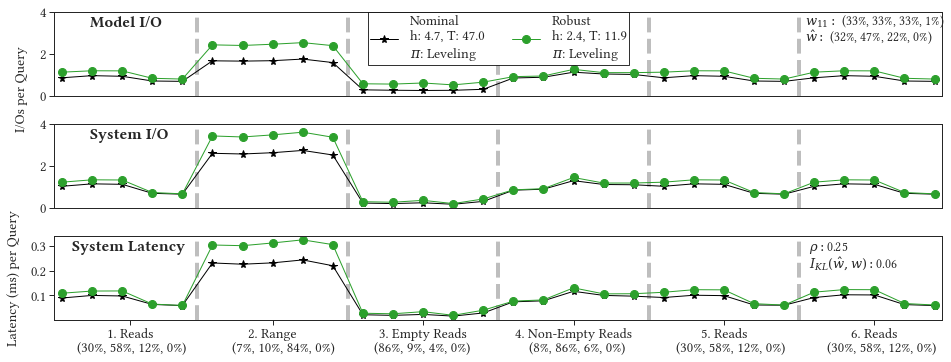

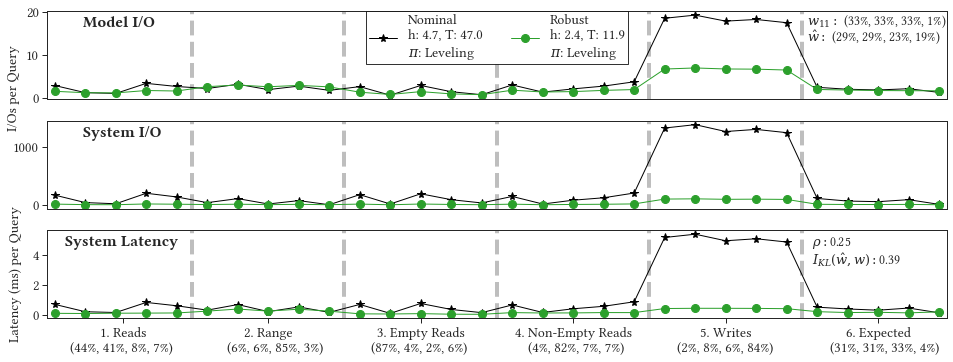

In [345]:
df1 = dp.read_csv('exp_05_no_writes_unique.csv')
df2 = dp.read_csv('exp_05_writes.csv')
wl_idx, N = 11, 1e7
graphs = (True, True, True)

df1_slice = df1[(df1['workload_idx'] == wl_idx) & (df1['N'] == N)].reset_index()
df1_slice = calc_ios(df1_slice)
df1_slice = calc_latency(df1_slice, readonly=True)

df2_slice = df2[(df2['workload_idx'] == wl_idx) & (df2['N'] == N)].reset_index()
df2_slice = calc_ios(df2_slice)
df2_slice = calc_latency(df2_slice)
# particular DF did not calculate compaction ms, but rather just write ms
# for mode in ['nominal', 'robust']:
#     write_ms = df2_slice[f'{mode}_w_ms'].sum()
#     workload_weight = df2_slice['w_s'] / df2_slice['w_s'].sum()
#     compact_normal_ms = write_ms * workload_weight
#     write_ms = compact_normal_ms
#     df2_slice[f'{mode}_ms'] = (
#             df2_slice[f'{mode}_z0_ms'] 
#             + df2_slice[f'{mode}_z1_ms']
#             + df2_slice[f'{mode}_q_ms']
#             + write_ms)

set_style()
fig1, axes1 = plot_cost_sessions(df1_slice, graphs, readonly=True)
axes1[0].set_ylim([0, 4])
axes1[1].set_ylim([0, 4])
set_style()
fig2, axes2 = plot_cost_sessions(df2_slice, graphs, readonly=False)
# ymax = max([ax.get_ylim()[1] for ax in axes])
# axes[0].set_ylim([0, axes[0].get_ylim()[1] * 1.5])
# axes[1].set_ylim([0, ymax])
set_size(fig1, width=14, height=sum(graphs)*1.75)
set_size(fig2, width=14, height=sum(graphs)*1.75)

save_fig(fig1, 'query_seq_read_2.pdf')
save_fig(fig2, 'query_seq_hybrid_2.pdf')

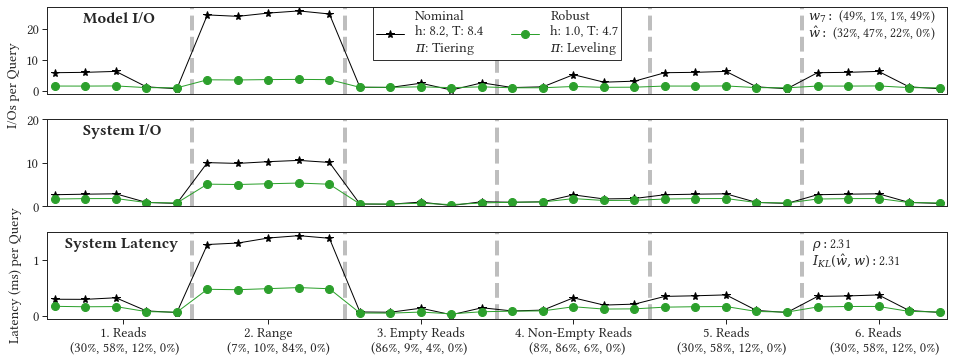

In [346]:
wl_idx, N = 7, 1e7
df1 = dp.read_csv('exp_03_no_writes.csv')
graphs = (True, True, True)
df_slice = df1[(df1['workload_idx'] == wl_idx) & (df1['N'] == N)].reset_index()
df_slice = calc_ios(df_slice)
df_slice = calc_latency(df_slice, readonly=True)

set_style()
fig, axes = plot_cost_sessions(df_slice, graphs, readonly=True)
axes[1].set_ylim([0, 20])
set_size(fig, width=14, height=sum(graphs)*1.75)

save_fig(fig, 'query_seq_read_1.pdf')